---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

<br>
<br>

# Overview

## Dimension Reduction

### PCA

In this section, I will use text frequency-inverse document TF-IDF as my embedding method to vectorize our reviews data. My rationale for using only TF-IDF, comes from the questionable results obtained when I used only the bag-of-words approach in the [EDA](../eda/main.ipynb) section. Specifically, when looking only at single term frequency per review class, there were multiple instances where meaningless words appeared most frequently across all review scores. I was able to address this issue by instead bagging pairs of words (bigrams) instead, which yielded more intuitive results. Regardless, I choose only to use TF-IDF in this section because it considers both how often a term appears in a single review (Term Frequency), and how rare the term is accross all reviews (Inverse Document Frequency). This two-pronged approach punishes words that are common across the entire review corpus, while favoring those that are less common and therefore may have greater meaning. For further context on TF-IDF, see the equations outlined in the literature review on the [Home](../../index.qmd) page. 

After embedding the review text, I will leverage several different unsupervised learning techniques. To begin, I use two types of dimension reduction techniques to collapse the high-dimensional tf-idf matrix into a low dimensional space for easier visualization. For this, I will use Principle Components Analysis (PCA) and t-distributed Stochastic Neighbor Embedding. In case you are unfamiliar with these two topics - PCA works by identifying an axes in high-dimensional space, along which the preserved variance of the data is maximized. These so-called "principal" components are eigenvectors of the covariance matrix, and their selection (i.e. how many principal components we take) depends on the respective share of total variance preserved by their eigenvalues[@EigenPCA]. 

**Here is a helpful visualization of what is going on in PCA:**
<br>
![](../../xtra/multiclass-portfolio-website/images/pca.gif){width="600px"} 
<br>
Source: [Builtin](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)

### t-SNE

On the other hand, t-SNE takes a non-linear, probabilistic approach to dimension reduction that works in two stages. First t-SNE constructs probability distributions over different pairs of high-dimensional points, where it then assigns higher probabilities to similar points and lower probabilities to dissimilar points[@WikiTSNE]. From there, t-SNE creates similar probability distributions in lower dimensional space, and shrinks the difference between the two distributions by minimizing the kullback-Leibler (KL) divergence between the two. In simple terms, the KL divergence simply measures the difference between two different probability distributions[@WikiKL]. T-SNE also requires the use of a `perplexity` hyperparameter, which represents a guess as to how many close neighbors a given point should have, or the "balance between preserving the global and local structure of the data"[@perplexity]. Feel free to head over [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) for a more robust explanation of t-SNE and KL divergence.

**Example of how `perplexity` Influences t-SNE Results**
<br>
![](../../xtra/multiclass-portfolio-website/images/perplexity.png){width="600px"}
<br>
Source: [Single Cell Discoveries](https://www.scdiscoveries.com/blog/knowledge/what-is-t-sne-plot/)

## Clustering

Once the data is properly collapsed into a lower-dimensional space, I will apply several clustering methods in order to better understand how different pieces of text group together. For this, I will use K-Means Clustering, Hierarchical Clustering, and DBSCAN. The goal for using clustering methods within the context of this study is to uncover underlying patterns in text for different review rating scores. 

### K-Means

As a first step, I will apply a K-Means clustering algorithm to the dimension-reduced data. The K-Means alorithm starts by randomly selecting $k$ points in the dataset, where $k$ is a hyperparameter that we can optimize by using the elbow method (covered below). From there, the algorithm takes these $k$ centroids and calculates their distance to all other points in the data set, assigning all of the closest points to their respective centroid. For my distance metric, I elect use euclidean distance[@eucdistance]: 

$$
\text{for a point} \ x = (x_1, x_2, ..., x_n) \ \text{and centroid} \ \mu = (\mu_1, \mu_2, \mu_n) \ \text{their distance} \ d(x,\mu) = \sqrt{\sum_{i=1}^{n}(x_{i}-\mu_{i})^2}
$$

After all data points have been assigned to their initial clusters, we calculate the mean of all data points for a given cluster[@Week8Slides]:

$$
\mu_{j}^{\text{new}} \leftarrow \frac{1}{|S_{j}|} \sum_{x_{i} \in{S_{j}}} x_{i}
$$

From there, we repeat our disance calculation and cluster re-assignment until convergence.

**Example of K-Means Convergence**
<br>
![](../../xtra/multiclass-portfolio-website/images/kmeans.gif){width="400px"}
<br>
Source: [Wikipedia](https://commons.wikimedia.org/wiki/File:K-means_convergence.gif)

### Hierarchical Clustering

In the next step of the process, I will use hierarchical clustering to help extract text groupings from the data. Unlike K-Means clustering's reliance on centroids, hierarchical clustering uses a tree-based model of distance called a 'dendrogram' to analyze similarity of data points. The dendrogram is constructed through an interative process, where it progressively combines or splits up clusters based on the similarity of points within them. The process ends either when all points in the data are combined into a single cluster, or when a predefined number of clusters are formed. 

There are two different types of hierarchical clustering, agglomerative and divisive. Here, I elect to use agglomerative or "bottom-up" hierarchical clustering to group my data points. Take for example the case when our data set a the set letters \[A,B,C,D,E,F]. An agglomerative clustering model starts by treating each letter as its own cluster. In the next step, the model combines the most similar clusters. For instance, the model may merge together clusters B and C, and D and E, resulting in the new clusters \[A, BC, DE, F]. From there, the model calculates cluster distances again, merging clusters DE and F, leaving us with \[A, BC, DEF]. Eventually, the model will merge all clusters such that we have a single cluster \[ABCDEF] (Thanks to [geeksforgeeks](https://www.geeksforgeeks.org/hierarchical-clustering/) for this example).

**Simple Example of Agglomerative Clustering:**
<br>
![](../../xtra/multiclass-portfolio-website/images/agglomerative.png){width="400px"}
<br>
Source: [GeeksforGeeks](https://www.geeksforgeeks.org/hierarchical-clustering/)


### DBCSCAN

Density-based spatial clustering of applications with noice, or DBSCAN is a density-based approach to clustering data points. I elect to use this method of clustering in my analysis because the two methods above (K-Means and Agglomerative) are geared towards finding spherical- or convex-shaped clusters (shapes that are more well-defined and less noisy). In the case of low-dimensional representations of text data, it is highly likely that clusters will not be well-defined, and therefore may require an alternative method for extracting them. That is precisely where DBSCAN comes into play. The DBSCAN algorithm requires `eps` and `MinPts` parameters, where eps "defines the neighborhood around data points," wherein the distance between two points that are close to eachother (neighbors) approximately equal to `eps`[@eps]. The parameter `MinPts` simply defines the minimum number of data points within the eps radius, where larger data sets typically require a higher value of `MinPts`[@eps].

**Example of DBSCAN Clustering**
<br>
![](../../xtra/multiclass-portfolio-website/images/DBSCAN.gif){width="400px"}


# Code 

## Loading in Data and Libraries

Here, I begin by loading in all of the necessary libraries for dimension reduction and clustering. I am using the [`sklearn`](https://scikit-learn.org/stable/) package for KMeans, DBSCAN, and agglomerative clustering, the `plotly` [python library](https://plotly.com/python/) for displaying interactive visualizations, and `pandas` for data manipulation. Below, I begin by unzipping the data file we worked with in the [EDA](../eda/main.ipynb) section.

In [39]:
# Data loading and manipulation packages
import pandas as pd
import numpy as np
import gzip

# Itertools product function to test all possible combinations of TF-IDF params for testing
from itertools import product


# Dimension reduction packages
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Clustering packages
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Pathway to raw data
data_path = "../../data/processed-data/reviews_short.csv.gz"

# Unzip the CSV file
with gzip.open(data_path, 'rb') as f:
    # Read the CSV file into a dataframe
    reviews = pd.read_csv(f)

reviews.head(1)

,reviewRating,vote,verified,reviewTime,reviewerID,productID,reviewerName,reviewText,summary,reviewTextClean,summaryClean,binary_target
0,5.0,2,False,2016-06-17,A7HY1CEDK0204,B00I9GYG8O,Jor El,If you're looking for Cinema 4K capabilities o...,Filmmakers will love this camera.,youre looking cinema k capabilities budget cam...,filmmakers love camera,positive


## Baseline Tests

In this section, I vectorize our cleaned text data using the `TfidfVectorizer` object found in the [`sklearn`](https://scikit-learn.org/stable/) library. Like I said previously, I experienced some issues relating to poor performance when applying `CountVectorizer` to single terms. Therefore, in this section, I elect to run the TfidfVectorizer` on single words and bigrams, as its consideration of word weights allows it to punish terms that are commonly found across all classes (review scores in this case).  

**The plan going forward:**

- Conduct some preliminary baseline tests using PCA and t-SNE, and see which performs better when given our reviews data
- Take the higher performer of the two, and build out a refined function that can be used to iteratively test different parameters
- Once I find a result that I like, save it to a new variable for modeling down the line
- Test out BERT's `SentenceTransformer` tool for full sentence embedding, and see if this produces any interesting results
- Perform clustering on the two best sets of reduced data.


In [3]:
#| echo: false
reviews['reviewTextClean'] = reviews['reviewTextClean'].astype(str)

### Basline: t-SNE vs PCA

To start off, lets create two simple plots of the data, using each of our two different dimension reduction techniques and TF-IDF embedding. To speed up the process, I will add a `N_SAMPLES` constant to allow for faster execution

**Sample TF-IDF Matrix**

In [8]:
N_SAMPLES = 2500
sampled_reviews = reviews.sample(n=N_SAMPLES, random_state=5000)

## Using tf-idf embedding
tfidf = TfidfVectorizer(max_features = 500, ngram_range=(1,2)) # Default params for our case: maximum features = 500 and consider both unigrams and bigrams 
X_tfidf = tfidf.fit_transform(sampled_reviews['reviewTextClean'])

**Standard PCA and t-SNE Reduction**

In [9]:
# Initializing PCA object 
pca = PCA(n_components=2, random_state=5000) #Default params for our case: 2 principal components
# Fitting to our embedded text
pca_data = pca.fit_transform(X_tfidf.toarray())

# Initializing t-SNE object
tsne = TSNE(n_components=2, perplexity=30, random_state=5000) # Default params for our case: 2 components, perplexity = 30, n_iter = 1000
# Fitting to our embedded text
tsne_data = tsne.fit_transform(X_tfidf.toarray())

**Plotting Results**

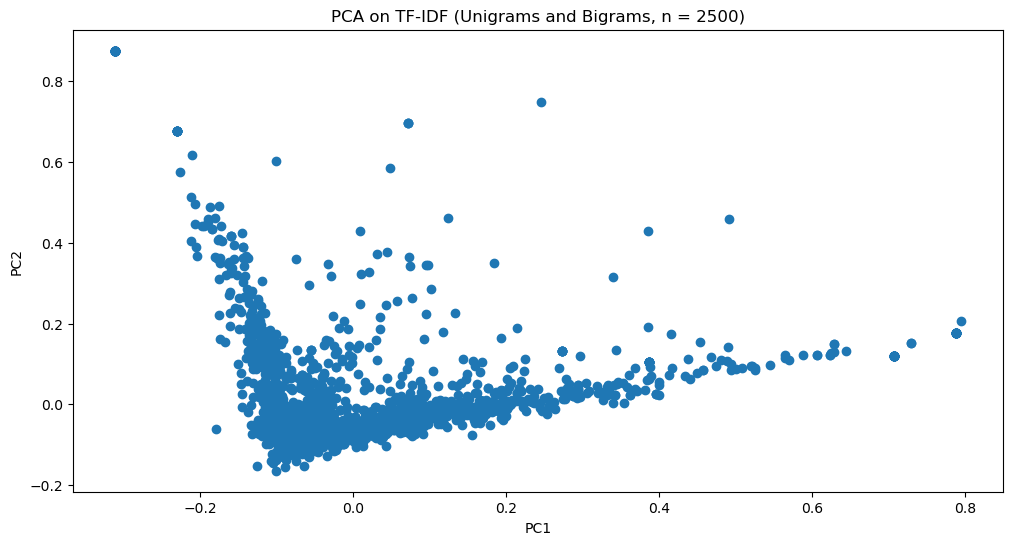

In [10]:
# Plotting PCA results
plt.figure(figsize=(12, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.title("PCA on TF-IDF (Unigrams and Bigrams, n = 2500)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

The above PCA plot demonstrates a very strong linear structure, where most of the data poinrs are concentrated along a single dominant direction. The most likely reason for this is that our princple components analysis was heavily influenced by a small group of dominant features. When thinking about this within the context of our reviews data, it makes sense that there are especially strong features, as reviews are often repetitive and contain a lot of the same content, especially adjectives and in this case names of standard electronics (i.e. batteries, keyboards, storage, etc.)

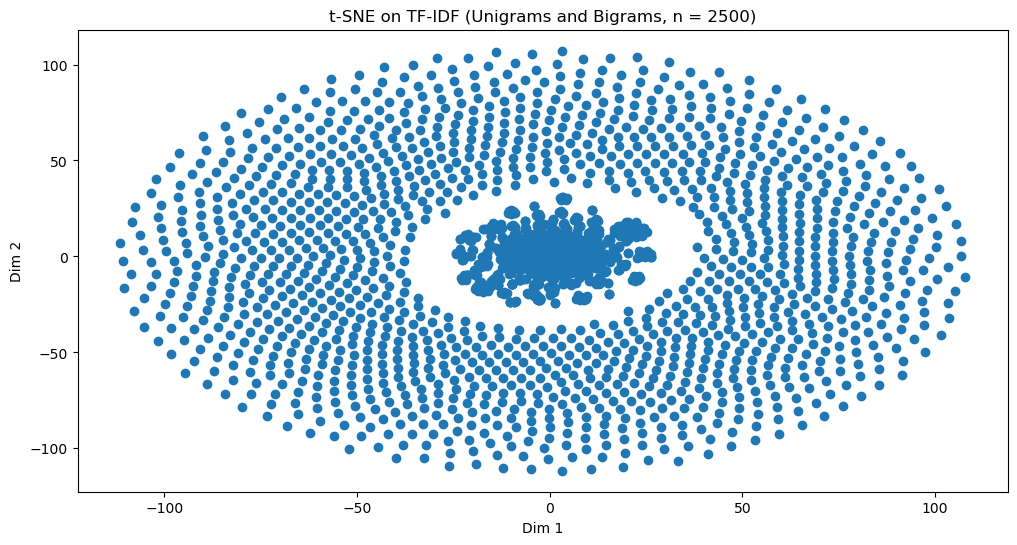

In [11]:
# Plotting t-SNE results
plt.figure(figsize=(12, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.title("t-SNE on TF-IDF (Unigrams and Bigrams, n = 2500)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

In contrast to our PCA plot, the t-SNE plot above shows a bit more promise. Ignoring the massive circle of points on the outer ring of the plot, we can see that t-SNE is able to better capture localized groups in the data, which makes it more ideal for clustering. Of course, we will have to tune some parameters to get a better result, but this is a strong first step. Going into this first stage, I had a feeling that t-SNE would outperform PCA when collapsing our TF-IDF embeddings. 

Moving forward, I will shift my focus toward refining our t-SNE reduction process. Below, I outline a function that I will use to help speed up the process.

## Parameter Optimization: Dimension Reduction

Below, I define the following functions:

- **`plot_embeddings()`** : A helper function that creates scatterplot of data across dimensions returned by t-SNE
- **`reduce_and_visualize()`**: Our main function that handles parameter adjustment for both t-SNE reduction and TF-IDF embedding. Controls sample size as well for quick iteration


**Note:** *For the `plot_embeddings()` function, I consulted an LLM to help write the code that produced the parameters table. At the bottom of this page, I provuide the original function used to display the plots, as well as a citation that includes my prompt[@gpt4o_textfunc].*

In [14]:
def plot_embeddings(data, title, labels=None, params=None):
    """
    This function creates a scatterplot of t-SNE reduced, TF-IDF embedded text data

    'data': np.array object (2D). contains our t-SNE output 
    'title': the name for our plot
    'labels': the condition we use to color our points (column in the data set)
    'params': is a dictionary that we define in redude_and_visualize() containing all of the parameters that we used
              in this function, it is used to plot them in a table next to our visualization.
    """

    # Initializing figure
    # plt.figure(figsize=(10,6))
    fig, ax = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={"width_ratios": [3, 1]})
    scatter = ax[0].scatter(data[:, 0], data[:, 1], # First and second axes produced by t-SNE
                          c = labels, # Fill condition (if any)
                          cmap = "viridis", # color scale
                          s = 10, # Size of points
                          alpha = 0.8) # Opacity of points
    ax[0].set_title(title)
    ax[0].set_xlabel("Dimension 1")
    ax[0].set_ylabel("Dimension 2")
    fig.colorbar(scatter, ax=ax[0], label = "Rating")

    # Handling params table
    if params:
        param_table = pd.DataFrame(list(params.items()), columns=["PARAMETER", "VALUE"])
        ax[1].axis("off")
        table = ax[1].table(cellText=param_table.values, colLabels=param_table.columns, loc="center")
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.auto_set_column_width(col=list(range(len(param_table.columns))))
    
    plt.tight_layout()
    plt.show()

Now, for our main function `reduce_and_visualize()`, we use the following parameters

- **reviews:** our pandas dataframe containing the target 'reviewTextClean' column
- **sample_size:** the number of samples we want to take from the dataframe
- **random_state:** our seed for random processes (sampling and t-SNE)
- **perplexity:** the perplexity value for our t-SNE process (Outlined above)
- **n_iter:** Number of iterations for t-SNE
- **max_features:** maximum number of TF-IDF features
- **ngram_range** N-gram range for TF-IDF (i.e. (1,1) is unigrams only, (1,2) is both unigrams and bigrams, and (2,2) is only bigrams)
- **min_df:** Minimum document frequency for TF-IDF
- **max_df:** Maximum document frequency for TF-IDF
- **intermediate_pca:** A boolean that states whether or not we use PCA before running t-SNE
- **return_df:** A boolean that states whether or not we return our collapsed dataframe (Will use this later If we want to keep the results)
- **show_plot:** A boolean that states whether we show the resulting plot or not.

The [scikit-learn documentation on t-SNE](https://scikit-learn.org/dev/modules/generated/sklearn.manifold.TSNE.html) highly recommends that we use another form of dimension reduction before running t-SNE to speed up the process of computation. Therefore, in this function I include the `intermediate_pca` parameter, which allows me to decide whether or not I run principal components analysis on the data before feeding it into t-SNE. The documentation advices that this process should reduce our data to a 'reasonable' amount of dimensions[@scikitTSNE]. In this function, I elect to go for 50 principle components. However, in future iterations I intend to optimize this parameter as well. For now, I will keep it static.

In [36]:
def reduce_and_visualize(
        reviews,
        sample_size=2500,
        random_state=5000,
        perplexity=30,
        n_iter=1000,
        max_features=500,
        ngram_range=(1,2),
        min_df=1,
        max_df=1.0,
        intermediate_pca=True,
        return_df = False,
        show_plot = True
    ):
    """
    This function:
    1) applies TF-IDF embedding to our text data
    2) (if intermediate_pca = True) runs intermediate PCA with n_components set to 50 
    3) Takes either raw data or PCA-reduced data and feeds it into t-SNE with set params
    """

    # Our first step is to break off our predefined sample data (defined in sample_size)
    if sample_size < len(reviews):
        sampled_reviews = reviews.sample(n=sample_size, random_state=random_state).reset_index(drop=True)
    else:
        sampled_reviews = reviews.reset_index(drop=True) 

    # Next we need to extract the relevant columns
    review_texts = sampled_reviews['reviewTextClean']
    review_ratings = sampled_reviews['reviewRating']

    # Now we can initialize our TF-IDF object and fit it to our cleaned review text
    tfidf = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df,    
    )

    X_tfidf = tfidf.fit_transform(review_texts)

    # Here, we are extracing the most important terms for each observation
    feature_names = np.array(tfidf.get_feature_names_out())
    most_important_terms = feature_names[np.argmax(X_tfidf.toarray(), axis=1)]


    # Now, we handle intermediate PCA conditions, converting our sparse matrix into a dense numpy array in both cases using .toarray()
    if intermediate_pca:
        print("Applying intermediate PCA...")
        # Initialize PCA object
        pca = PCA(n_components=50, random_state=random_state)
        # Applying to X_tfidf
        X_reduced = pca.fit_transform(X_tfidf.toarray()) 
    else:
        X_reduced = X_tfidf.toarray()


    # Once that is handled, we can feed our dense array into t-SNE
    print("Applying t-SNE...")
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state, n_iter=n_iter) # Here we collapse to 2-Dimensions, but in some cases we may need 3
    reduced_data = tsne.fit_transform(X_reduced)

    # Creating a dataframe for later clustering 
    reduced_df = pd.DataFrame(reduced_data, columns=["Dim1", "Dim2"])
    reduced_df["Rating"] = review_ratings.values
    reduced_df["Most_Important_Term"] = most_important_terms

    # Gathering our parameters for the plot
    params = {
        "Sample Size": sample_size,
        "Perplexity": perplexity,
        "Iterations": n_iter,
        "Max Features": max_features,
        "N-gram Range": ngram_range,
        "Min DF": min_df,
        "Max DF": max_df,
        "Intermediate PCA": intermediate_pca
    }

    if show_plot:
        # After all of that, we can now plot our results...
        print("Plotting results...")
        plot_embeddings(
            reduced_data,
            title = f"t-SNE With TF-IDF Embeddings",
            labels = review_ratings,
            params = params
        )

    # Return reduced dataframe
    if return_df:
        return reduced_df


### Test 1: Intermediate PCA

Let's test out this function with all of the same paremeters as our base case while also including intermediate PCA


Applying intermediate PCA...
Applying t-SNE...
Plotting results...


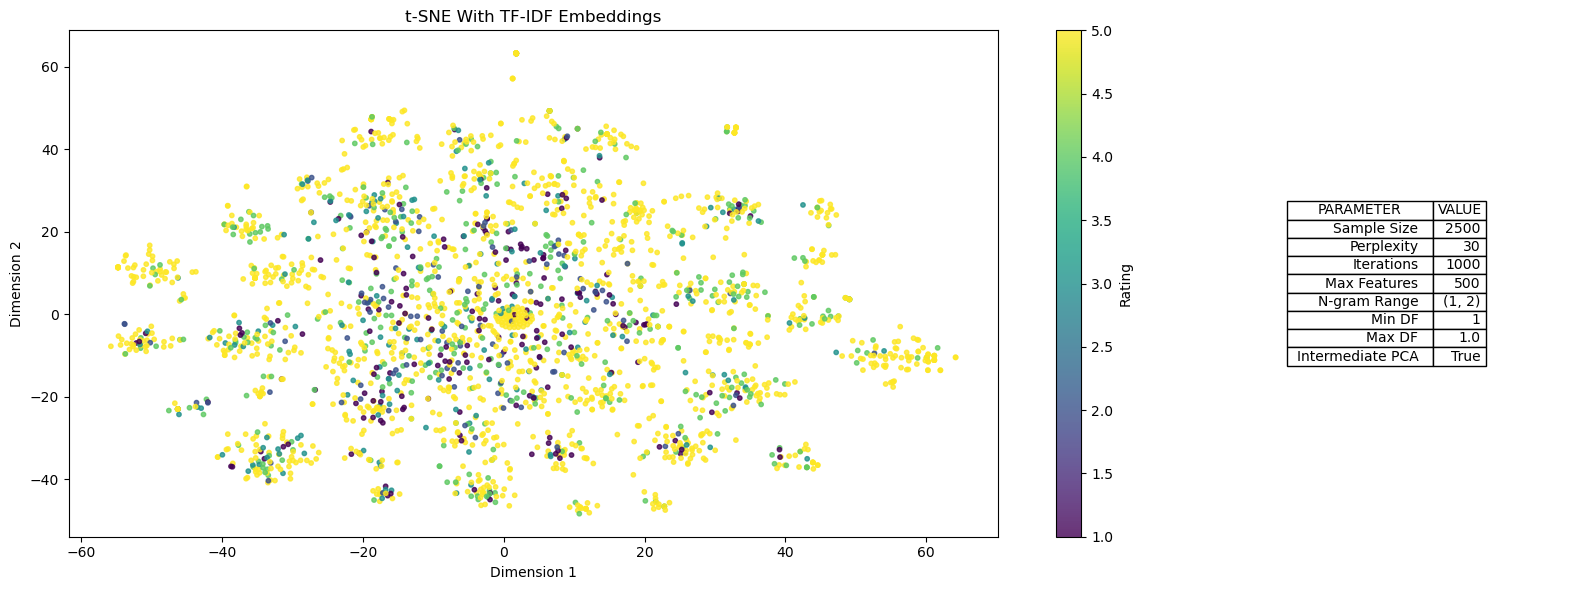

In [16]:
# Testing out this code
reduce_and_visualize(reviews)

Ths plot above shows results of our algorithm, when using all of the same parameters as our default case above, with the only difference being the inclusion of intermediate PCA. At a glance, this result seems to drastically improve our standard t-SNE process by a long-shot. The data points are much more spread out, and there are nice clusters beginning to form. The first method was able to extract some local structure, but it also yielded a massive spiral of points around said structure. 

Taking this back to the context of our data, we unfortuately see litle to no relationship between cluster groupings and ratings score - meaning that the rating associated with a given review may not be related to the location of the review's most important word in a high dimensional space. Nonetheless, there are clusters in this data, and the sections below will help us identify what they represent.

### Test 2: No Intermediate PCA

In this test, I will apply all of the same parameters without the use of intermediate PCA. The goal here its usefulness in extracting local relationships in our text data

Applying t-SNE...
Plotting results...


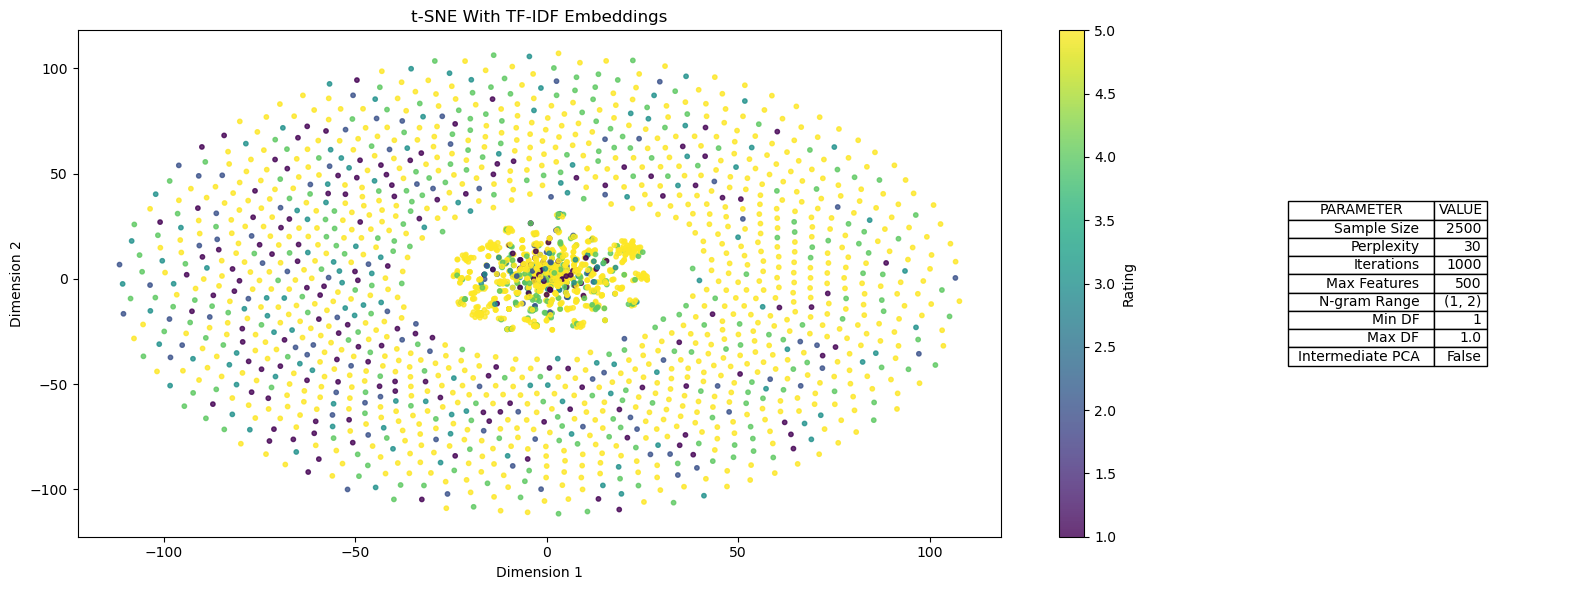

In [17]:
reduce_and_visualize(reviews, intermediate_pca=False)

The plot above confirms that intermediate PCA is a critical step in producing useful results when reducing our data

### Test 3: Adjusting Perplexity

In this section, I will apply low and high `perplexity` parameters to our algorithm, and check performance for both. As a refresher, perplexity controls the size of each data point's neighborhood. For a more robust explanation, please refer to the [openTSNE](https://opentsne.readthedocs.io/en/latest/parameters.html) documentation.

**Higher `perplexity` (100)**

Applying intermediate PCA...
Applying t-SNE...
Plotting results...


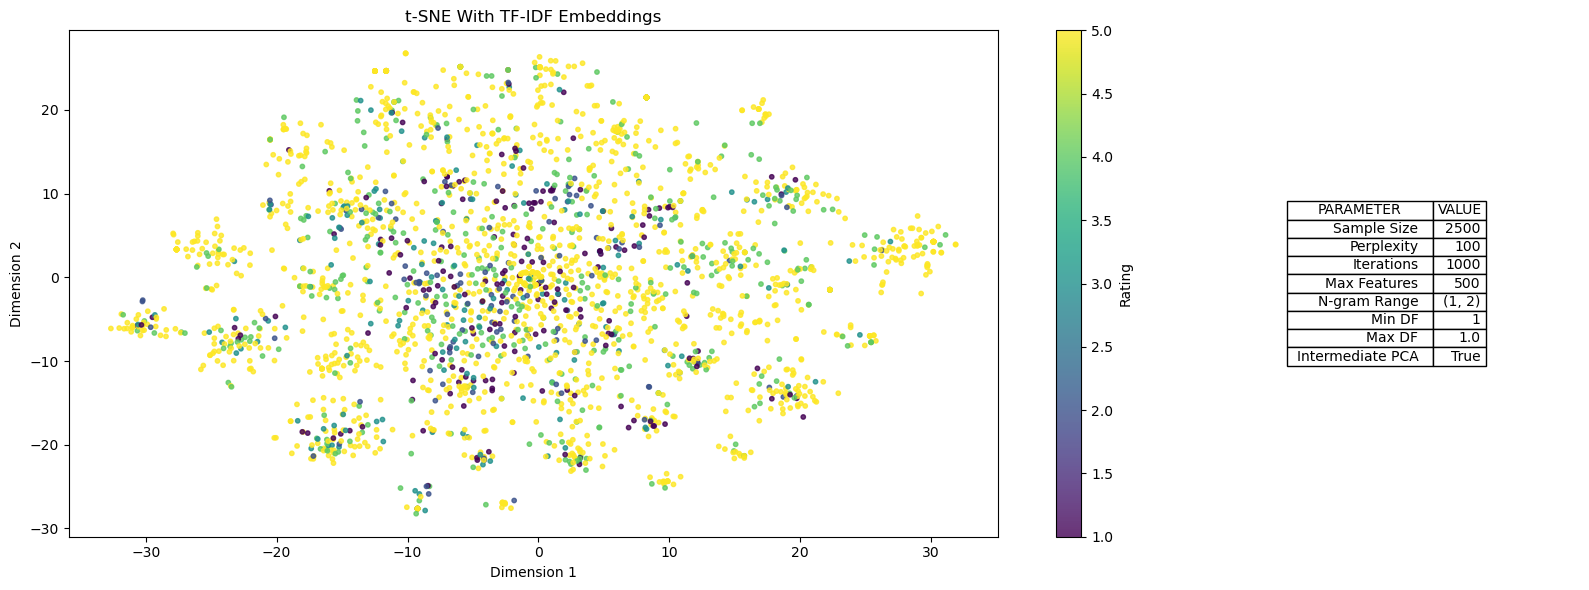

In [18]:
reduce_and_visualize(reviews, perplexity=100)

**Lower `perplexity` (10)**

Applying intermediate PCA...
Applying t-SNE...
Plotting results...


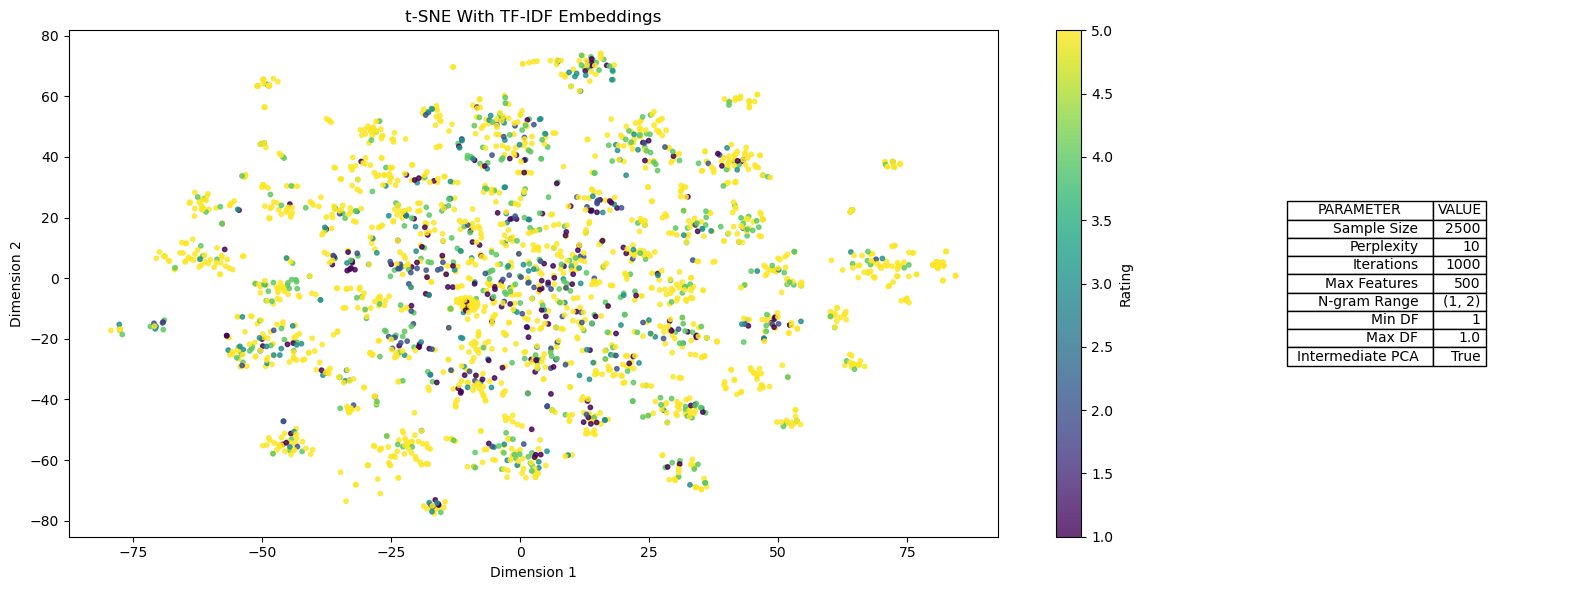

In [19]:
reduce_and_visualize(reviews, perplexity=10)

**Interpretation**

The first plot uses standard parameters, with a higher `perplexity` value of 100. In this plot, the distribution of points is more spread out, with larger clusters than our initial plot where `perplexity` was set to 30. Increased perplexity is synonymous with increased neighborhood size. Therefore, it makes sense to see more global groupings with fewer local clusters as a result. In the second plot, I lower `perplexity` from 30 to 10, which results in much tighter and local clusters. In the second case, we are lowering the size of a data point's neighborhood, wich allows t-SNE to capture more localized groups. In the latter case, there is almost too much emphasis placed on local groups, which may yield more clusters when modeling than what would be appropriate. Therefore, from here I elect to use a value of `perplexity` that is high enough to maintain global relationships, while not being too high to ignore more nuanced local relationships

### Test 4: Adjusting Document Frequency in TF-IDF Embedding

In this section, I will tweak the `max_df` parameter that applies to our initial TF-IDF embedding. The `max_df` parameter sets an upper bound on the document frequency calculated for certain terms (both unigrams and bigrams in our case). In other words, lowering the value for `max_df` will drop the threshold for which terms are dropped based on their document frequency. The rationale behind lowering this value is to ignore terms that are common in our data, which may help to create more well-defined clusters

**Lower `max_df` (0.8)**


Applying intermediate PCA...
Applying t-SNE...
Plotting results...


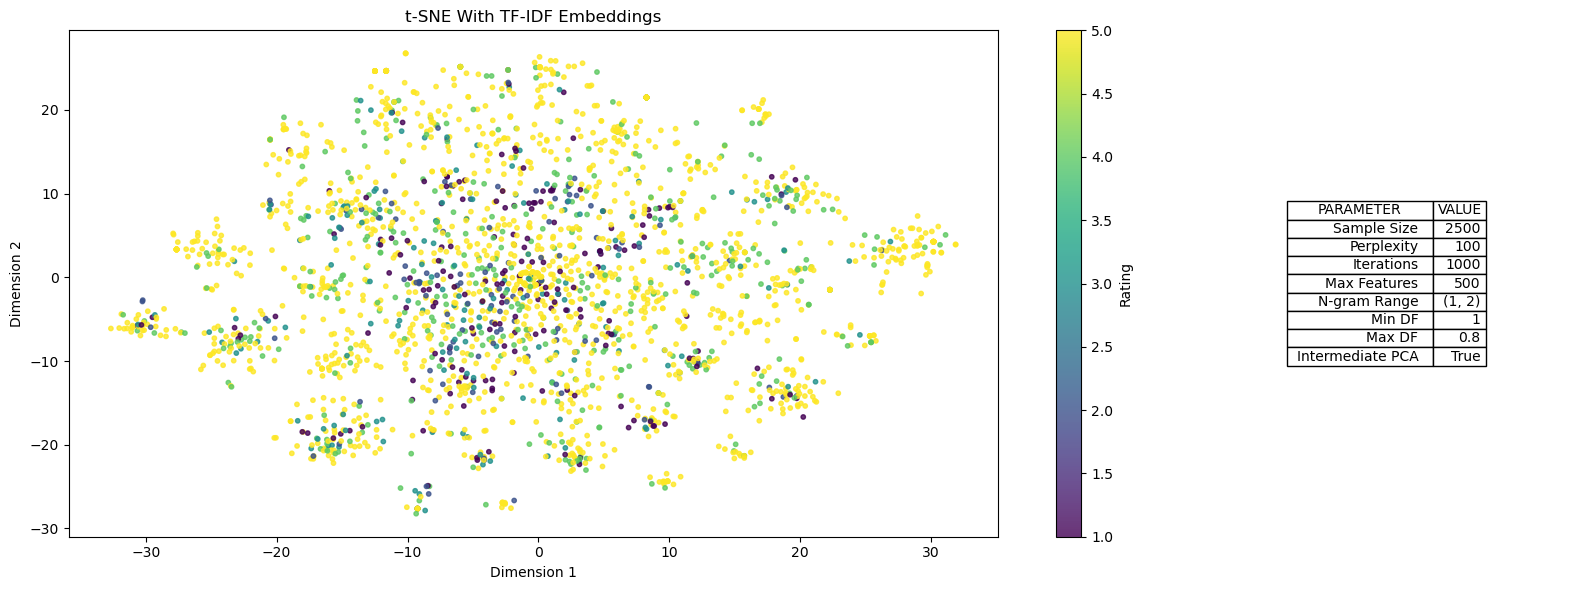

In [23]:
reduce_and_visualize(reviews, perplexity=100, max_df=0.8)

Not much of a change compared to plot above, let's try an even lower value:

**Lower `max_df` (0.6)**

Applying intermediate PCA...
Applying t-SNE...
Plotting results...


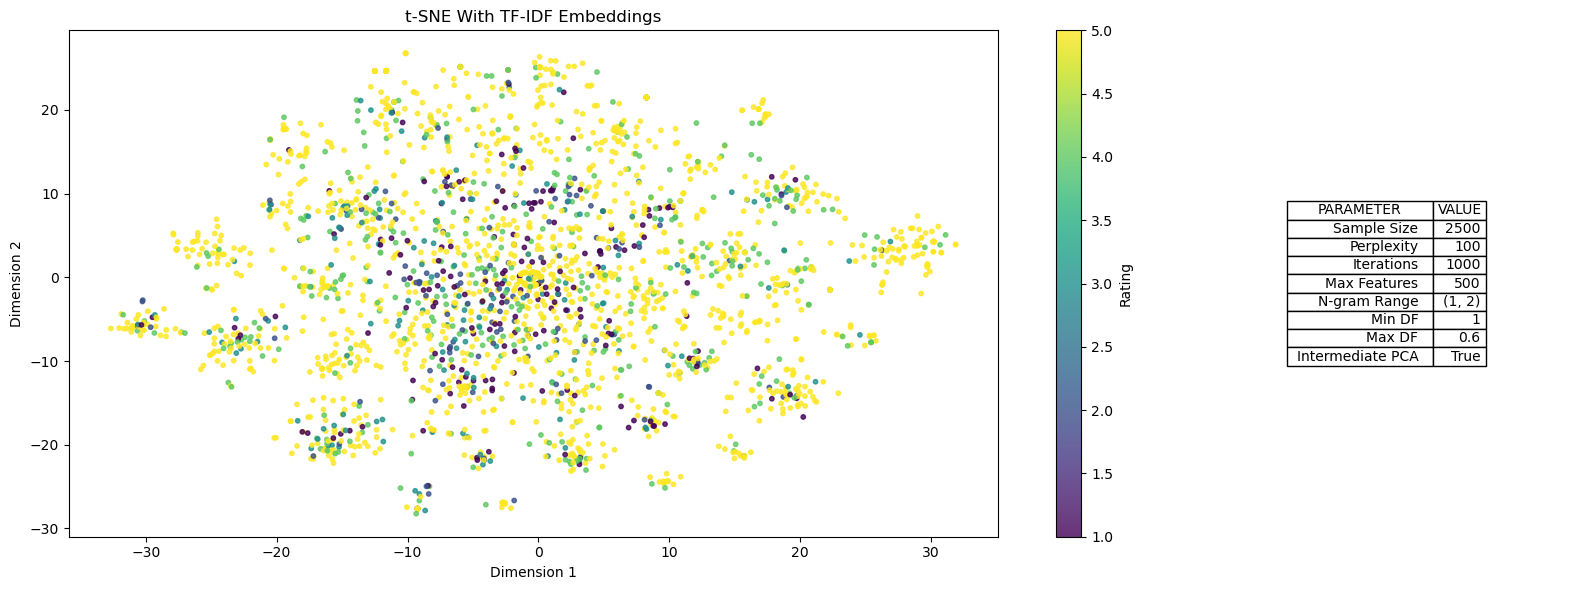

In [25]:
reduce_and_visualize(reviews, perplexity=100, max_df=0.6)

Not much of a change in either case. Let's move on to tweaking our next parameter: `max_features`

### Test 5: Tweaking Number of Iterations in t-SNE

The t-SNE parameter `n_iter` adjusts the number of iterations that the t-SNE algorithm runs through in order to optimize KL-Divergence[@scikitTSNE]. In this test, I will raise the value of `n_iter` to increase the number of iterations t-SNE uses when trying to collapse dimensions

**Increasing `n_iter` (2000)**

Applying intermediate PCA...
Applying t-SNE...
Plotting results...


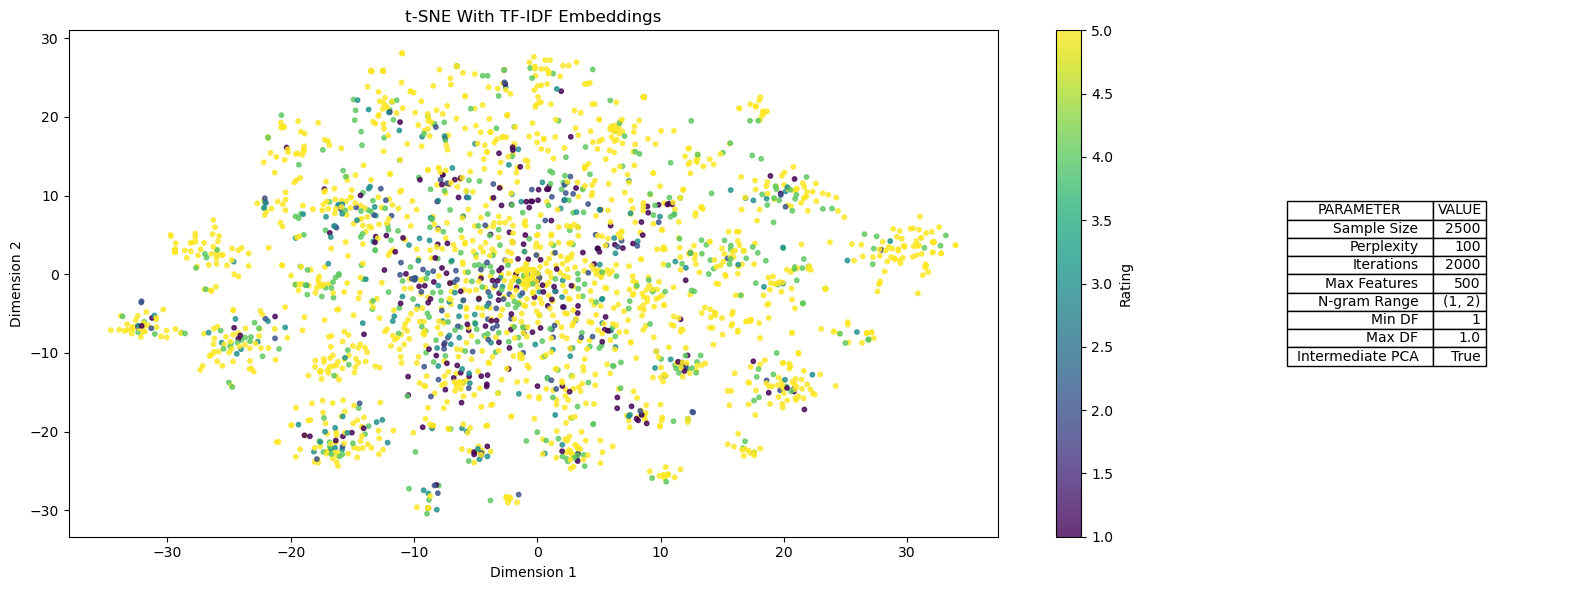

In [26]:
reduce_and_visualize(reviews, perplexity=100, n_iter=2000)

Again, we don't see much change compared to plots with less iterations.

### Fine-tuning Perplexity

After all of that, it seems that adjusting our `perplexity` parameter seems to impact our results the most. Thus, in this section I will test different perplexity values that are all greater than 30 - saving the dataset that yields the most promising results.

**Testing Different Perplexity Values**

In [ ]:
# Set values to test
perplexities = [x for x in range(40, 140, 20)]
# [40, 60, 80, 100, 120]

# Looping through values 
## for value in perplexities:
##     print(f"PERPLEXITY VALUE: {value}")
##     reduce_and_visualize(reviews, perplexity=value)

For the sake of saving space, I omit the resulting plots from this process. In short, this loop yielded more dispersion between points as our perplexity parameter increased. When looking at the results for each, the plot corresponding to a `perplexity` of 100 provided the best balance between global and local groups. 

Having said all of that, the dataset that I will use for clustering comes from the following configuration from the `reduce_and_visualize` function:

- Perplexity: 100
- Iterations: 1000
- Max Features: 500
- N-gram Range: (1,2) (Unigrams and Bigrams)
- Minimum Document Freq: 1
- Maximum Document Freq: 1.0
- Intermediate PCA: True (n_components = 50)

For the sake of clustering speed, I will use a sample of 10,000 rows taken from reviews.

In [38]:
# Gathering our dataset 
reduced_df = reduce_and_visualize(reviews, sample_size=10000, perplexity=100, show_plot=False, return_df=True)
# Printing first rows
reduced_df.head(1)

,Dim1,Dim2,Rating,Most_Important_Term
0,-15.568591,25.8913,1.0,charger


## Clustering

### KMeans Clustering

**Elbow Method and Silhouette Score**



In [ ]:
# Set a range of clusters to test
k_clusters = [x for x in range(2, 30)]

# Initialize inertia and silhouette score lists for tracking
intertia = []
silhouette_avg = []



**Original `plot_embeddings()` function that I gave to GPT-4o:**

```
def plot_embeddings(data, title, labels=None):
    """
    This function creates a scatterplot of t-SNE reduced, TF-IDF embedded text data

    'data': np.array object (2D). contains our t-SNE output 
    'title': the name for our plot
    'labels': the condition we use to color our points (column in the data set)
    """
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap="viridis", s=10, alpha=0.7)
    plt.colorbar(scatter, label="Rating")
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()
```